# Fantasy Baseball Roster Analysis

## Goal
Determine the optimal evaluation window for roster decisions and identify missed opportunities for Team PJR.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# specific plotting config
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# 1. Load Data
BASE_PATH = r'c:\Users\peter\Desktop\vscode\main\.data_lake\01_Bronze\fantasy_baseball'

roster_df = pd.read_csv(f'{BASE_PATH}\\roster_history_2025.csv')
stats_df = pd.read_csv(f'{BASE_PATH}\\stats_mlb_daily_2025.csv')
player_map_df = pd.read_csv(f'{BASE_PATH}\\player_map.csv')
teams_df = pd.read_csv(f'{BASE_PATH}\\teams_espn_season_2025.csv')

In [3]:
# 2. Preprocess Data
# standardizing dates
stats_df['date'] = pd.to_datetime(stats_df['date'])
roster_df['start_date'] = pd.to_datetime(roster_df['start_date'])
roster_df['end_date'] = pd.to_datetime(roster_df['end_date'])

# Merge stats with player map to get ESPN IDs (if needed) or keep using MLB IDs if roster uses them.
# roster_history_2025.csv has 'player_id'. Let's check if it's ESPN or MLB.
# player_map.csv has 'espn_player_id' and 'statcast_player_id'. 
# We will assume roster_df uses ESPN IDs (typical for fantasy exports).

# Ensure ID columns are strings for merging
roster_df['player_id'] = roster_df['player_id'].astype(str)
player_map_df['espn_player_id'] = player_map_df['espn_player_id'].astype(str)
player_map_df['statcast_player_id'] = player_map_df['statcast_player_id'].astype(str).str.replace(r'\.0$', '', regex=True)

# Stats DF likely uses MLB IDs (playerId). 
stats_df['playerId'] = stats_df['playerId'].astype(str)

# Merge Map to Stats to link to Roster
stats_merged = stats_df.merge(player_map_df, left_on='playerId', right_on='statcast_player_id', how='left')

print("Stats merged shape:", stats_merged.shape)
stats_merged.head()

Stats merged shape: (71757, 46)


,date,scoring_period,playerName,playerId,teamId,b_or_p,2B,3B,AB,B_BB,...,isHome,opponentId,team_abbrev,espn_player_id,first_name,full_name,last_name,player_eligible_slots,player_pro_team,statcast_player_id
0,2025-03-27,1,Cal Raleigh,663728,136,batter,0.0,0.0,3.0,1.0,...,True,133,Seattle Mariners,41292,Cal,Cal Raleigh,Raleigh,"['C', 'UTIL', 'BE', 'IL']",Sea,663728
1,2025-03-28,2,Cal Raleigh,663728,136,batter,0.0,0.0,3.0,1.0,...,True,133,Seattle Mariners,41292,Cal,Cal Raleigh,Raleigh,"['C', 'UTIL', 'BE', 'IL']",Sea,663728
2,2025-03-29,3,Cal Raleigh,663728,136,batter,0.0,0.0,3.0,1.0,...,True,133,Seattle Mariners,41292,Cal,Cal Raleigh,Raleigh,"['C', 'UTIL', 'BE', 'IL']",Sea,663728
3,2025-03-30,4,Cal Raleigh,663728,136,batter,0.0,0.0,3.0,0.0,...,True,133,Seattle Mariners,41292,Cal,Cal Raleigh,Raleigh,"['C', 'UTIL', 'BE', 'IL']",Sea,663728
4,2025-03-31,5,Cal Raleigh,663728,136,batter,0.0,0.0,5.0,0.0,...,True,116,Seattle Mariners,41292,Cal,Cal Raleigh,Raleigh,"['C', 'UTIL', 'BE', 'IL']",Sea,663728


In [4]:
# 3. Value Calculation (Z-Scores)
# Categories: 
# Batters: R, HR, RBI, SB
# Pitchers: QS, SVHD, K, ERA (neg), WHIP (neg)

# Define weights/stats
batter_stats = ['R', 'HR', 'RBI', 'SB']
pitcher_stats = ['QS', 'SVHD', 'K', 'ERA', 'WHIP'] # Note: ERA/WHIP need inversion

# Helper to calculate Daily Value
def calculate_daily_value(df):
    # Initialize Value
    df['Daily_Value'] = 0.0
    
    # Calculate mean/std for normalization from the *entire season* to keep scale consistent
    # Alternatively, calculate per-day Z-scores. Per-day handles high-offense days better.
    # Let's use Daily Z-scores against the field of players who played that day.
    
    metrics = batter_stats + ['QS', 'SVHD', 'K'] # Counting stats
    
    # We need to compute derived rate stats for Z-scores (ERA/WHIP are derived per game? No, typically accumulated)
    # For daily value, we can use 'impact' on ERA/WHIP. 
    # Impact = (LeagueERA - PlayerERA) * IP / 9 approx. 
    # Or just simple Z-score of the raw stat if valid (ERA is infinite if 0 IP).
    # Let's stick to Counting Stats + 'Game Score' approximation for simplicty if ERA/WHIP are noisy.
    # Actually, let's look at what counts for fantasy. 
    # Let's use: R/HR/RBI/SB + (K/QS/SVHD) + (IP - ER*A) approach for 'Value'. 
    # But to be precise to the user's categories:
    # Batters: Z(R) + Z(HR) + Z(RBI) + Z(SB)
    # Pitchers: Z(QS) + Z(SVHD) + Z(K) - Z(ER) - Z(WHIP_contribution)
    # WHIP contribution ~ H + BB. 
    
    for col in batter_stats:
        if col in df.columns:
            # Simple Z-score per day
            mean = df[col].mean()
            std = df[col].std()
            if std == 0: std = 1
            df[f'z_{col}'] = (df[col] - mean) / std
            df['Daily_Value'] += df[f'z_{col}'].fillna(0)
            
    # Pitchers
    # QS, SVHD, K are positive
    p_pos = ['QS', 'SVHD', 'K']
    for col in p_pos:
        if col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            if std == 0: std = 1
            df[f'z_{col}'] = (df[col] - mean) / std
            df['Daily_Value'] += df[f'z_{col}'].fillna(0)
            
    # Negative stats: ER, H+BB (proxy for WHIP)
    # We want LOW ER, LOW H+BB
    if 'ER' in df.columns:
        mean = df['ER'].mean()
        std = df['ER'].std()
        if std == 0: std = 1
        df['z_ER'] = (df['ER'] - mean) / std
        df['Daily_Value'] -= df['z_ER'].fillna(0) # Subtract bad stats
        
    df['Whip_Proxy'] = df['H'] + df['BB'] if 'BB' in df.columns else df['H'] + df['P_BB'] # Check column names
    # P_H and P_BB are likely Pitcher Hits/Walks in the dataset
    whip_col_H = 'P_H' if 'P_H' in df.columns else 'H'
    whip_col_BB = 'P_BB' if 'P_BB' in df.columns else 'BB'
    
    if whip_col_H in df.columns and whip_col_BB in df.columns:
         df['Whip_Proxy'] = df[whip_col_H] + df[whip_col_BB]
         mean = df['Whip_Proxy'].mean()
         std = df['Whip_Proxy'].std()
         if std == 0: std = 1
         df['z_WHIP'] = (df['Whip_Proxy'] - mean) / std
         df['Daily_Value'] -= df['z_WHIP'].fillna(0)

    return df

daily_stats = stats_merged.groupby('date').apply(calculate_daily_value).reset_index(drop=True)
daily_stats[['date', 'playerName', 'Daily_Value']].head()

C:\Users\peter\AppData\Local\Temp\ipykernel_8984\1054018178.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_stats = stats_merged.groupby('date').apply(calculate_daily_value).reset_index(drop=True)


,date,playerName,Daily_Value
0,2025-03-18,Shohei Ohtani,2.358693
1,2025-03-18,Michael Busch,-1.200333
2,2025-03-18,Seiya Suzuki,-1.200333
3,2025-03-18,Pete Crow-Armstrong,-1.200333
4,2025-03-18,Andy Pages,0.579180


Window 1 days correlation: 0.0821
Window 4 days correlation: 0.1522
Window 7 days correlation: 0.1858
Window 10 days correlation: 0.2120
Window 13 days correlation: 0.2345
Window 16 days correlation: 0.2525
Window 19 days correlation: 0.2627
Window 22 days correlation: 0.2717
Window 25 days correlation: 0.2778
Window 28 days correlation: 0.2850
Window 31 days correlation: 0.2922
Window 34 days correlation: 0.3001
Window 37 days correlation: 0.3076
Window 40 days correlation: 0.3153
Window 43 days correlation: 0.3203
Window 46 days correlation: 0.3239
Window 49 days correlation: 0.3261
Window 52 days correlation: 0.3266
Window 55 days correlation: 0.3249
Window 58 days correlation: 0.3233
Window 61 days correlation: 0.3236
Window 64 days correlation: 0.3246
Window 67 days correlation: 0.3254
Window 70 days correlation: 0.3263
Window 73 days correlation: 0.3297
Window 76 days correlation: 0.3345
Window 79 days correlation: 0.3402
Window 82 days correlation: 0.3460
Window 85 days correlat

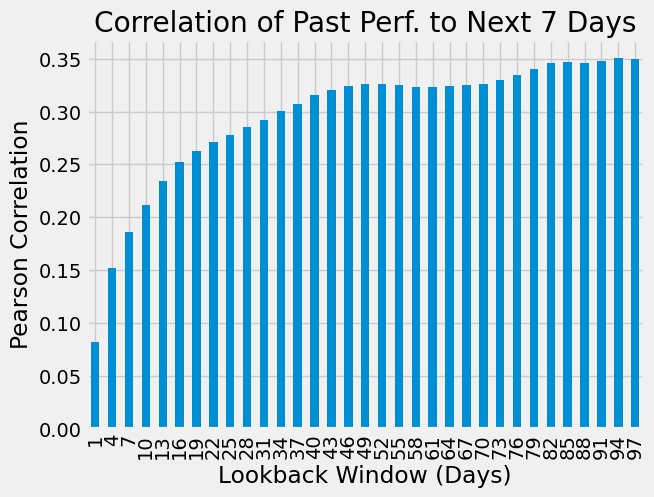


Optimal Evaluation Window: 94 days


In [8]:
# 4. Time Series Analysis
# Determine optimal lookback window by correlating Past Avg Value vs Future 7-day Avg Value

player_daily = daily_stats[['date', 'espn_player_id', 'Daily_Value']].copy()
# Remove players appearing multiple times per day (doubleheaders) - take sum
player_daily = player_daily.groupby(['date', 'espn_player_id']).sum().reset_index()

# Create continuous date range for each player to handle off-days (fill 0? No, fill NaN or skip?)
# For fantasy, 0 is real (didn't play). 
# Pivot to wide format: Date x Player
pivot_df = player_daily.pivot(index='date', columns='espn_player_id', values='Daily_Value').fillna(0)

windows = [i for i in range(1, 100, 3)]
correlations = {}

for w in windows:
    # Rolling Mean of Past X Days
    # shift(1) to ensure we don't include "today" in the past, or inclusive? 
    # Lookback window w (e.g. avg of last 7 days). 
    rolling_past = pivot_df.rolling(window=w).mean()
    
    # Future 7 days (including tomorrow). 
    # We shift rolling(-7) backwards? 
    # Rolling(7).mean().shift(-7) gives the mean of t+1 to t+7?
    # Pandas rolling is looking BACK. So to get future, we reverse, roll, reverse, or use shift.
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=7)
    rolling_future = pivot_df.rolling(window=indexer).mean().shift(-1) # Next 7 days starting tomorrow
    
    # align data
    # Flatten to calculate correlation
    # We correlation the flattened vectors of (Past_Value, Future_Value)
    past_flat = rolling_past.stack()
    future_flat = rolling_future.stack()
    
    # Combine
    combined = pd.concat([past_flat, future_flat], axis=1).dropna()
    combined.columns = ['past', 'future']
    
    corr = combined['past'].corr(combined['future'])
    correlations[w] = corr
    print(f"Window {w} days correlation: {corr:.4f}")

# Plot correlations
s_corr = pd.Series(correlations)
s_corr.plot(kind='bar', title='Correlation of Past Perf. to Next 7 Days')
plt.xlabel('Lookback Window (Days)')
plt.ylabel('Pearson Correlation')
plt.show()

best_window = s_corr.idxmax()
print(f"\nOptimal Evaluation Window: {best_window} days")